In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.nonparametric.kernel_regression import KernelReg

tbg = pd.read_csv("./trends_by_income_groups.csv", index_col=0, parse_dates=["date"])

220


<AxesSubplot:xlabel='date'>

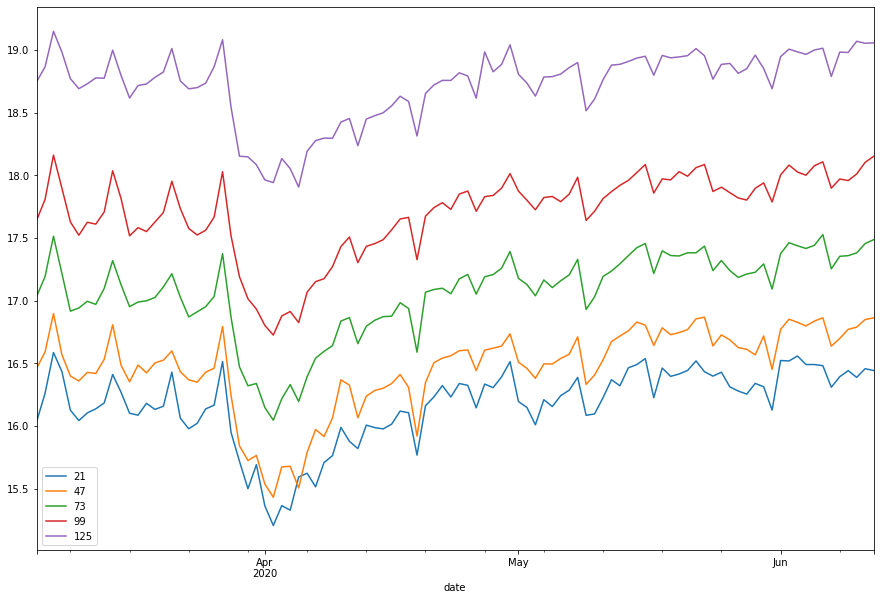

In [2]:
cols = list(tbg.columns[2:])

tbg_agg = (
    tbg[
        (tbg["group"] < 100)
        & (tbg["date"] > pd.to_datetime("2018-09-01"))
    ]
    .assign(group_collapsed=lambda x: x["group"] // 20)
    .groupby(["date", "group_collapsed"])
    .agg({key: np.sum for key in tbg.columns[2:]})
    .reset_index()
    [["date", "group_collapsed"] + cols]
    .groupby("date")
    .apply(lambda x: pd.Series(np.log(np.ravel(x.values[:, 1:]) + 1000), ))
)


# idx = 7  # !!!
# idx = 9  # !!!
# idx = 12  # !!!!!
# idx = 19  # ?
# idx = 20  # !!!!!
idx = 21  # !!
# idx = 22  # !!!!!
print(cols[idx])
tbg_agg.iloc[550:650, (np.arange(tbg_agg.shape[1] // len(cols))*len(cols)) + idx].plot(figsize=(15, 10))

In [3]:
# Manualy selected covid-dependent categories
cats = [2, 7, 9, 12, 19, 20, 22]
cols = list(tbg.columns[2 + np.array(cats)])

tbg_agg_2 = (
    tbg[
        (tbg["group"] < 100)
        & (tbg["date"] > pd.to_datetime("2018-09-01"))
    ]
    .assign(group_collapsed=lambda x: x["group"] // 1)
    .groupby(["date", "group_collapsed"])
    .agg({key: np.sum for key in tbg.columns[2:]})
    .reset_index()
    [["date", "group_collapsed"] + cols]
    .groupby("date")
    .apply(lambda x: pd.Series(np.log(np.ravel(x.values[:, 1:]) + 1000), ))
)

tbg_agg_2.columns = sum([
        [
            f"{cat}__{group:03d}"
            for cat in cols
        ] for group in range(tbg_agg_2.shape[1] // len(cols))
    ], [])

In [4]:
T = tbg_agg_2.shape[0]


new_year_range = 115, 135
new_year_cleanup = np.zeros((T, new_year_range[1] - new_year_range[0]))
for t in range(*new_year_range):
    new_year_cleanup[[t, t+365, t+731], t-new_year_range[0]] += 1

cleanup_stuff = np.hstack((
    [
        np.arange(T).reshape((-1, 1)).astype(int)%7 == wd
        for wd in range(7)
    ]
    + [
        np.arange(T).reshape((-1, 1)),
        new_year_cleanup,
    ]
))

proj_residuals = lambda X, Y: Y - X.dot(np.linalg.inv((X.T).dot(X) / X.shape[0]).dot((X.T).dot(Y) / X.shape[0]))

In [5]:
series = proj_residuals(cleanup_stuff, tbg_agg_2.values)
series -= np.mean(series, axis=0, keepdims=True, dtype=np.float64)
series /= np.std(series, axis=0, keepdims=True, dtype=np.float64)
series

array([[-10.08133068,  -6.74313664,  -8.54109866, ...,   0.13216292,
         -0.38261855,   0.04597322],
       [ -7.61761039,  -6.1786809 ,  -8.3647756 , ...,   1.82997613,
         -0.01632622,   0.02493567],
       [ -4.98655139,  -6.51498523,  -6.55202501, ...,   1.51257364,
          0.14762318,  -0.18574614],
       ...,
       [ -1.12578408,  -1.33878485,  -1.16112294, ...,   0.91422147,
          0.86804299,   0.57914714],
       [ -1.30183345,  -1.25066827,  -1.18147823, ...,   0.34729282,
          0.77048384,   1.29092952],
       [ -1.1189106 ,  -0.58664153,  -0.90955274, ...,  -0.12132233,
          0.58490429,   1.20382537]])

In [6]:
def run_PCA(array: np.ndarray):
    U, S, Vt = np.linalg.svd(array, full_matrices=False)
    U *= S.reshape((1, -1))
    if U.shape[0] > U.shape[1]:
        signer = np.sign(U[-1, :]).reshape((1, -1))
    else:
        signer = np.sign(U[-1, :]).reshape((-1, 1))
    Vt *= signer
    U *= signer
    return U, S, Vt

U, S, Vt = run_PCA(series)

In [7]:
S_sum = np.dot(np.square(S), np.triu(np.ones((S.shape[0], S.shape[0]))))
S_sum = S_sum/S_sum[-1]
feature_num = np.sum(S_sum <= 0.9)
print(feature_num)
np.square(S)[:5] / np.sum(np.square(S)[:5])

175


array([0.76946476, 0.08779025, 0.06576984, 0.04487996, 0.03209519])

<AxesSubplot:>

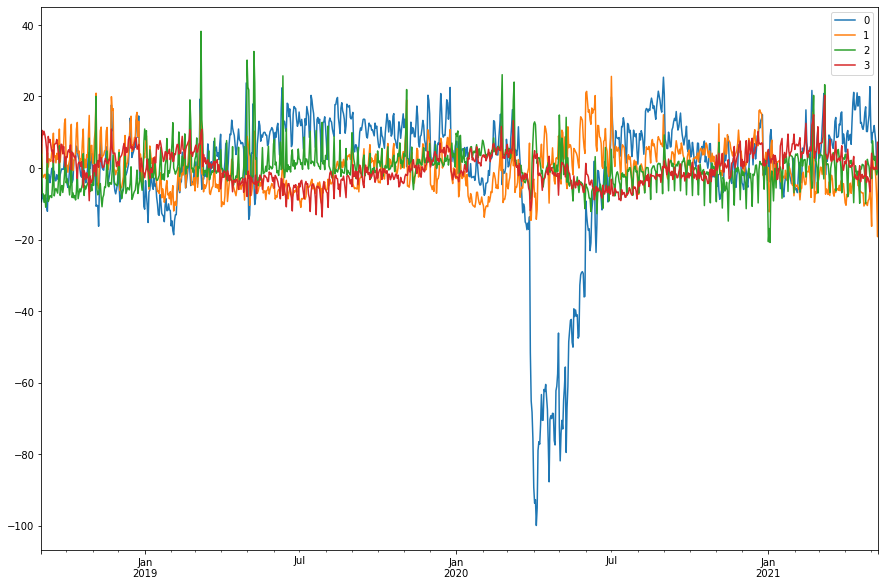

In [8]:
pd.DataFrame(U[:, :4], index=sorted(list(set(tbg_agg_2.reset_index()["date"])))).plot(figsize=(15, 10))

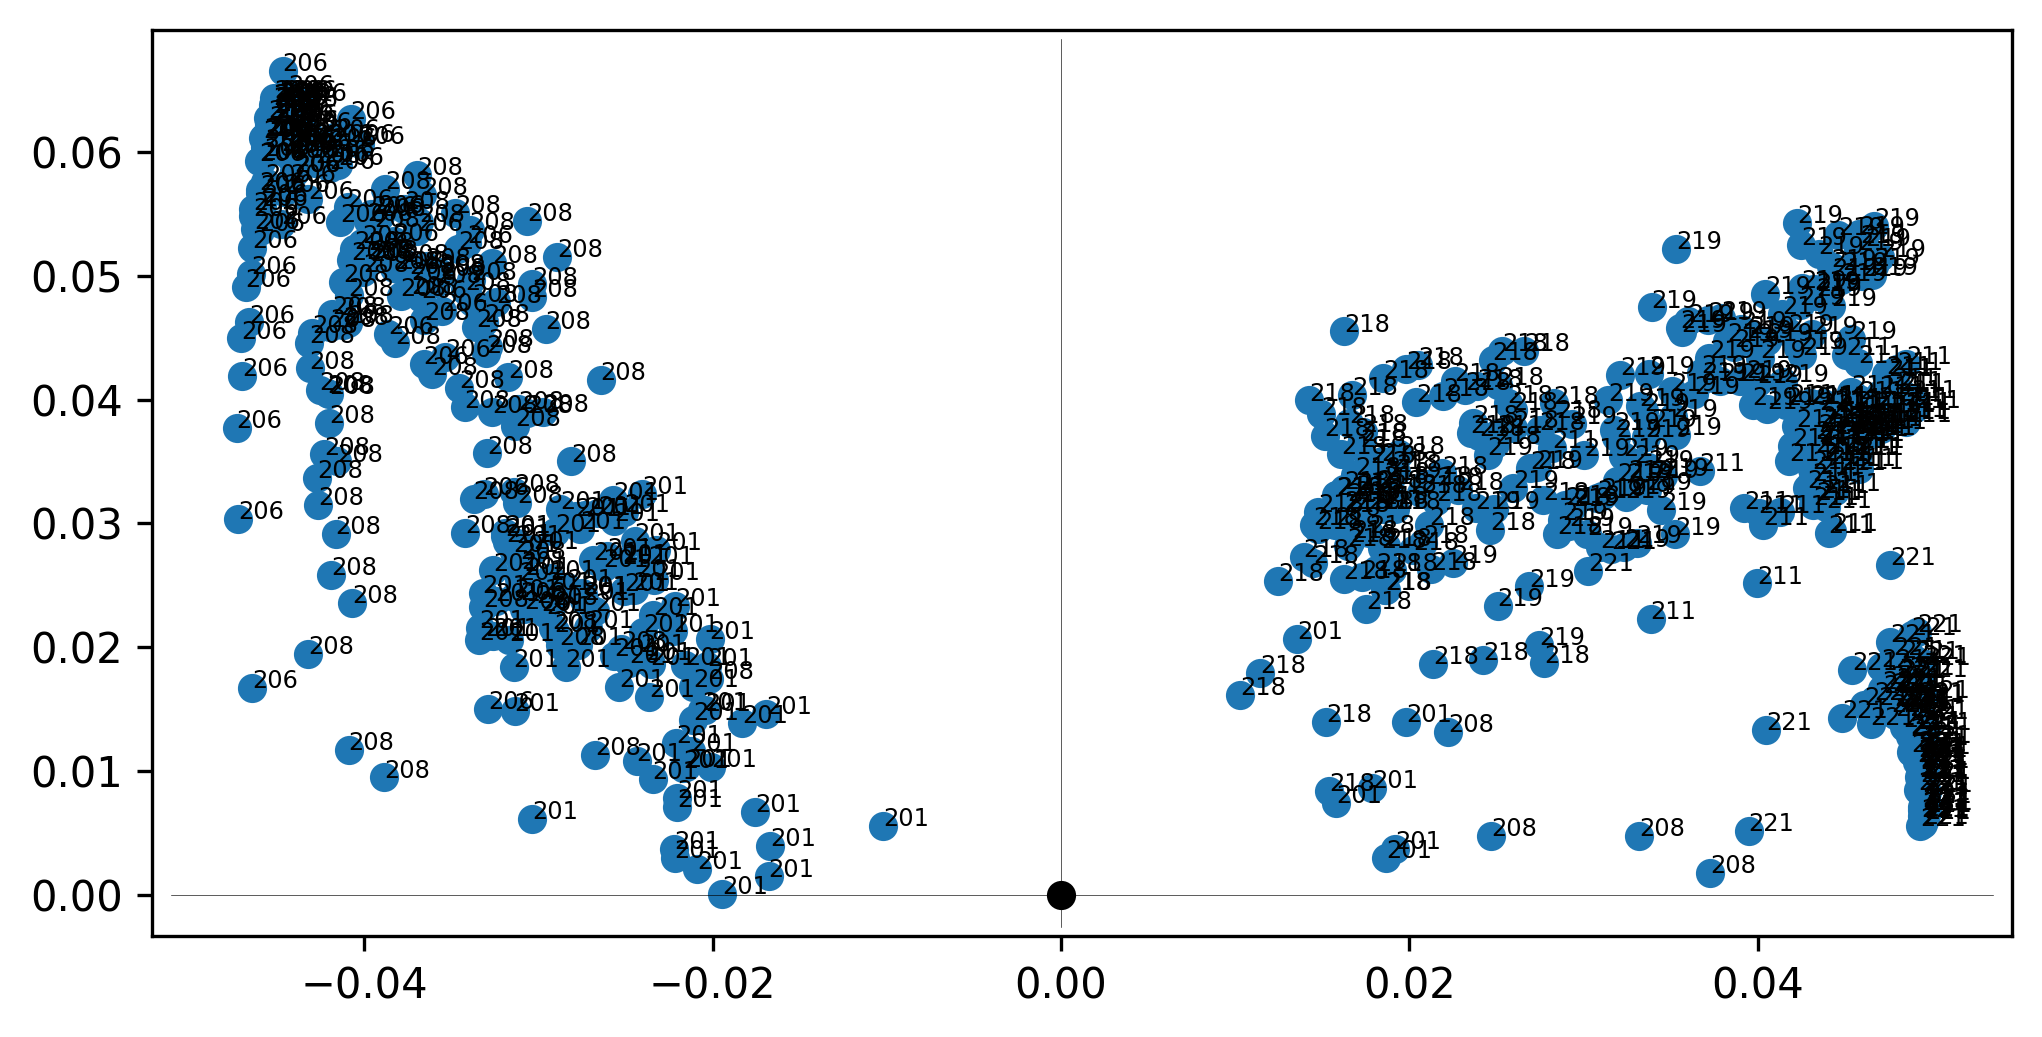

In [9]:
fig = plt.figure(figsize=plt.figaspect(0.5), dpi=300)
ax = fig.add_subplot(1, 1, 1)

x, y = Vt[0]*np.sign(Vt[1]), Vt[1]*np.sign(Vt[1])
ax.scatter(x, y)
ax.scatter(0, 0, color="black")
ax.axhline(0, 0.01, 0.99, color="black", linewidth=0.15)
ax.axvline(0, 0.01, 0.99, color="black", linewidth=0.15)
for i, col_name in enumerate(tbg_agg_2.columns):
    ax.annotate(col_name[:-5], (x[i], y[i]), fontsize="xx-small")

plt.show()

<AxesSubplot:>

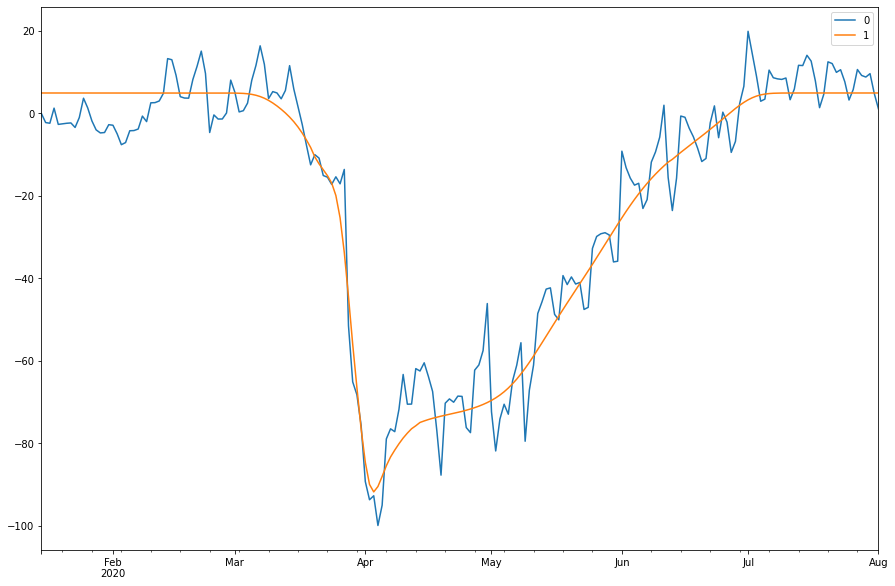

In [10]:
level = np.mean(np.hstack([U[:540, 0], U[700:, 0]]))

Fitted = {
    bw: KernelReg(U[:, 0], np.arange(T), "c", reg_type="ll", bw=[bw]).fit(np.arange(T))[0]
    for bw in [1, 2, 3, 5, 7]
}
art = np.ones(T) * level
art[552:670] = Fitted[7][552:670] * 1.05
art[560:564] = Fitted[5][560:564]
art[580:586] = Fitted[3][580:586] * 1.05
art[562:576] = Fitted[2][562:576]
art[576:580] = Fitted[1][576:580]

ReFitted = KernelReg(art, np.arange(T), "c", reg_type="ll", bw=[3]).fit(np.arange(T))[0]
art[545:565] = ReFitted[545:565]
art[582:590] = ReFitted[582:590]
art[650:690] = ReFitted[650:690]

ReFitted = KernelReg(art, np.arange(T), "c", reg_type="ll", bw=[1]).fit(np.arange(T))[0]
art[575:588] = ReFitted[575:588]

plotodata = np.vstack([U[:, 0], art]).T
pd.DataFrame(plotodata, index=sorted(list(set(tbg_agg_2.reset_index()["date"]))))[500:700].plot(figsize=(15, 10))

In [11]:
art -= np.mean(art, axis=0, keepdims=True, dtype=np.float64)
art /= np.std(art, axis=0, keepdims=True, dtype=np.float64)

packed_art = pd.DataFrame(
    art.reshape((-1, 1)),
    columns=["COVID_factor"],
    index=pd.Index(sorted(list(set(tbg_agg_2.reset_index()["date"]))), name="date")
)
packed_art.to_csv("./covid_factor.csv")